In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### RandomForest

In [2]:
# classifier
def RandomForestC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = RandomForestClassifier(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor (optional)
def RandomForestR(train_x, test_x, train_y, test_y, config):
    
    clf = RandomForestRegressor(**config, n_jobs = -1)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


# classifeir for all resampling datasets
def runall_ForestC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = RandomForestC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set
    

# regressor for all resampling datasets (optional)
def runall_ForestR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = RandomForestR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Optuna

In [3]:
# creator of optuna study for random forest
def RandomForest_creator(train_data, mode, num_valid = 5, label = 'GB') :
    
    def objective(trial) :

        param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 12, step = 2),
            'max_depth': trial.suggest_int('max_depth', 3, 21, step = 3),
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = RandomForestC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = RandomForestR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

### Full Experiment

In [4]:
def full_randomforest(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_RandomForest_{i}',
                                         creator = RandomForest_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = RandomForestC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], 
                                  return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## 

### For a Run

#### Load Data

In [4]:
### training data ### 
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (1404, 88)  balance ratio: 1.0
Dimension of dataset 2 : (1368, 88)  balance ratio: 1.0
Dimension of dataset 3 : (1376, 88)  balance ratio: 1.0
Dimension of dataset 4 : (1378, 88)  balance ratio: 1.0
Dimension of dataset 5 : (1370, 88)  balance ratio: 1.01
Dimension of dataset 6 : (1369, 88)  balance ratio: 1.02
Dimension of dataset 7 : (1317, 88)  balance ratio: 1.1
Dimension of dataset 8 : (1380, 88)  balance ratio: 1.0
Dimension of dataset 9 : (759, 88)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (2304, 97)  balance ratio: 1.0
Dimension of dataset 2 : (2226, 97)  balance ratio: 1.0
Dimension of dataset 3 : (2256, 97)  balance ratio: 1.0
Dimension of dataset 4 : (2258, 97)  balance ratio: 1.0
Dimension of dataset 5 : (2271, 97)  balance ratio: 0.99
Dimensio

#### Search for The Best Hyperparameters

In [5]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = False, 
                                     n_iter = 20, 
                                     filename = 'runhist_array_m2m4_m5_3criteria_RandomForest', 
                                     creator = RandomForest_creator
                                    )

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-04 09:23:37,481] A new study created in memory with name: no-name-2fd61b31-9f46-4346-ac03-f6a787cb0c92


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.8973277074542897 
Recall: 0.8318122555410691 
Aging Rate: 0.4634941329856584
Precision: 0.8758434547908233 
Recall: 0.8461538461538461 
Aging Rate: 0.4830508474576271
Precision: 0.8773722627737226 
Recall: 0.7835723598435462 
Aging Rate: 0.44654498044328556
[I 2022-03-04 09:23:39,190] Trial 0 finished with value: 0.8506317399212567 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 0 with value: 0.8506317399212567.
Precision: 0.9973718791064389 
Recall: 0.9895697522816167 
Aging Rate: 0.49608865710560623
Precision: 0.9960835509138382 
Recall: 0.9947848761408083 
Aging Rate: 0.49934810951760106
Precision: 0.9960732984293194 
Recall: 0.9921773142112125 
Aging Rate: 0.4980443285528031
[I 2022-03-04 09:23:41,712] Trial 1 finished with value: 0.9943369255197556 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 1 with value: 0.9943369255197556.
Precision: 0.8667621776504298 
Recall: 0.788787483

Precision: 0.9832904884318766 
Recall: 0.9973924380704041 
Aging Rate: 0.5071707953063885
Precision: 0.9921156373193167 
Recall: 0.984354628422425 
Aging Rate: 0.49608865710560623
[I 2022-03-04 09:24:20,579] Trial 17 finished with value: 0.9902226733896594 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 8 with value: 0.9963009798395727.
Precision: 0.9986824769433466 
Recall: 0.9882659713168188 
Aging Rate: 0.49478487614080835
Precision: 1.0 
Recall: 0.9882659713168188 
Aging Rate: 0.4941329856584094
Precision: 0.9973718791064389 
Recall: 0.9895697522816167 
Aging Rate: 0.49608865710560623
[I 2022-03-04 09:24:23,148] Trial 18 finished with value: 0.9936669260301204 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 8 with value: 0.9963009798395727.
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Agi

Precision: 0.9857881136950905 
Recall: 0.9947848761408083 
Aging Rate: 0.5045632333767927
Precision: 1.0 
Recall: 0.9804432855280313 
Aging Rate: 0.49022164276401564
[I 2022-03-04 09:24:49,647] Trial 34 finished with value: 0.9910687655949267 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 8 with value: 0.9963009798395727.
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9973890339425587 
Recall: 0.9960886571056062 
Aging Rate: 0.49934810951760106
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2022-03-04 09:24:50,630] Trial 35 finished with value: 0.9936837619375251 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 8 with value: 0.9963009798395727.
Precision: 0.9986893840104849 
Recall: 0.9934810951760105 
Aging Rate: 0.4973924380704042
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Agin

[I 2022-03-04 09:25:22,940] A new study created in memory with name: no-name-36e05e52-b3d1-45e6-984c-88f944cd4914


Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
[I 2022-03-04 09:25:22,880] Trial 49 finished with value: 0.9928245204093956 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 8 with value: 0.9963009798395727.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.8888888888888888 
Recall: 0.896 
Aging Rate: 0.504
Precision: 0.8941018766756033 
Recall: 0.8893333333333333 
Aging Rate: 0.49733333333333335
Precision: 0.8960526315789473 
Recall: 0.908 
Aging Rate: 0.5066666666666667
[I 2022-03-04 09:25:25,605] Trial 0 finished with value: 0.8953760879326245 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 6}. Best is trial 0 with value: 0.8953760879326245.
Precision: 0.792 
Recall: 0.792 
Aging Rate: 0.5
Precision: 0.8151260504201681 
Recall: 0.776 
Aging Rate: 0.476
Precision: 0.7966339410939691 
Recall: 0.7573333333333333 
Aging Rate: 0.47533333333333333
[I 2022-03-04 09:25:27,485] Trial 1 finished with value: 0.7878562128122094 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.8953760879326245.
Precision: 0.8018433179723502 
Recall: 0.696 
Aging Rate: 0.434
Precision: 0.8200589970501475 
Recall: 0.7413333333333333 
Aging Rate: 0.452
Precision: 0.81

Precision: 0.9764089121887287 
Recall: 0.9933333333333333 
Aging Rate: 0.5086666666666667
Precision: 0.9893333333333333 
Recall: 0.9893333333333333 
Aging Rate: 0.5
Precision: 0.9662775616083009 
Recall: 0.9933333333333333 
Aging Rate: 0.514
[I 2022-03-04 09:25:59,080] Trial 18 finished with value: 0.9845834730024063 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 11 with value: 0.9887393957038974.
Precision: 0.9788079470198675 
Recall: 0.9853333333333333 
Aging Rate: 0.5033333333333333
Precision: 0.9853137516688919 
Recall: 0.984 
Aging Rate: 0.49933333333333335
Precision: 0.9708994708994709 
Recall: 0.9786666666666667 
Aging Rate: 0.504
[I 2022-03-04 09:26:04,253] Trial 19 finished with value: 0.9804946115236919 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 11 with value: 0.9887393957038974.
Precision: 0.9815546772068511 
Recall: 0.9933333333333333 
Aging Rate: 0.506
Precision: 0.9790026246

Precision: 0.9867724867724867 
Recall: 0.9946666666666667 
Aging Rate: 0.504
Precision: 0.9920106524633822 
Recall: 0.9933333333333333 
Aging Rate: 0.5006666666666667
Precision: 0.9802890932982917 
Recall: 0.9946666666666667 
Aging Rate: 0.5073333333333333
[I 2022-03-04 09:26:30,675] Trial 36 finished with value: 0.9902669831853723 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 36 with value: 0.9902669831853723.
Precision: 0.9828496042216359 
Recall: 0.9933333333333333 
Aging Rate: 0.5053333333333333
Precision: 0.9867197875166003 
Recall: 0.9906666666666667 
Aging Rate: 0.502
Precision: 0.9750656167979003 
Recall: 0.9906666666666667 
Aging Rate: 0.508
[I 2022-03-04 09:26:32,594] Trial 37 finished with value: 0.9865190604573906 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 36 with value: 0.9902669831853723.
Precision: 0.984251968503937 
Recall: 1.0 
Aging Rate: 0.508
Precision: 0.9854111405835

[I 2022-03-04 09:26:56,465] A new study created in memory with name: no-name-337fb312-8516-4485-a142-2b8373a19bfe


Precision: 0.9906666666666667 
Recall: 0.9906666666666667 
Aging Rate: 0.5
[I 2022-03-04 09:26:56,404] Trial 49 finished with value: 0.9888781937017231 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 38 with value: 0.9911458724477537.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9025032938076416 
Aging Rate: 0.4512516469038208
Precision: 1.0 
Recall: 0.8866930171277997 
Aging Rate: 0.44334650856389984
Precision: 1.0 
Recall: 0.9025032938076416 
Aging Rate: 0.4512516469038208
[I 2022-03-04 09:27:01,271] Trial 0 finished with value: 0.9458170197619894 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.9458170197619894.
Precision: 1.0 
Recall: 0.922266139657444 
Aging Rate: 0.461133069828722
Precision: 1.0 
Recall: 0.9104084321475626 
Aging Rate: 0.4552042160737813
Precision: 1.0 
Recall: 0.927536231884058 
Aging Rate: 0.463768115942029
[I 2022-03-04 09:27:03,226] Trial 1 finished with value: 0.9583569355664455 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 1 with value: 0.9583569355664455.
Precision: 1.0 
Recall: 0.9367588932806324 
Aging Rate: 0.4683794466403162
Precision: 1.0 
Recall: 0.9499341238471674 
Aging Rate: 0.47496706192

Precision: 1.0 
Recall: 0.9367588932806324 
Aging Rate: 0.4683794466403162
Precision: 1.0 
Recall: 0.9380764163372859 
Aging Rate: 0.46903820816864294
Precision: 1.0 
Recall: 0.9314888010540184 
Aging Rate: 0.4657444005270092
[I 2022-03-04 09:27:58,922] Trial 19 finished with value: 0.9666417388616241 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 4 with value: 0.9864183969636079.
Precision: 1.0 
Recall: 0.9591567852437418 
Aging Rate: 0.4795783926218709
Precision: 1.0 
Recall: 0.9736495388669302 
Aging Rate: 0.4868247694334651
Precision: 1.0 
Recall: 0.9670619235836627 
Aging Rate: 0.48353096179183136
[I 2022-03-04 09:28:00,057] Trial 20 finished with value: 0.9830189041331464 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 4 with value: 0.9864183969636079.
Precision: 1.0 
Recall: 0.9841897233201581 
Aging Rate: 0.49209486166007904
Precision: 1.0 
Recall: 0.9815546772068511 
Aging Rate: 0.4907

Precision: 1.0 
Recall: 0.9670619235836627 
Aging Rate: 0.48353096179183136
Precision: 1.0 
Recall: 0.9644268774703557 
Aging Rate: 0.48221343873517786
Precision: 1.0 
Recall: 0.9459815546772069 
Aging Rate: 0.47299077733860345
[I 2022-03-04 09:28:51,181] Trial 38 finished with value: 0.9791291893641407 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 21 with value: 0.9888863682811833.
Precision: 1.0 
Recall: 0.9565217391304348 
Aging Rate: 0.4782608695652174
Precision: 1.0 
Recall: 0.9631093544137023 
Aging Rate: 0.48155467720685113
Precision: 1.0 
Recall: 0.9657444005270093 
Aging Rate: 0.48287220026350464
[I 2022-03-04 09:28:56,020] Trial 39 finished with value: 0.9805198526702026 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 21 with value: 0.9888863682811833.
Precision: 1.0 
Recall: 0.8998682476943346 
Aging Rate: 0.4499341238471673
Precision: 1.0 
Recall: 0.9156785243741765 
Aging Rate: 0

[I 2022-03-04 09:29:26,757] A new study created in memory with name: no-name-31a37f29-382d-4a59-92b4-eac48737db84


Precision: 1.0 
Recall: 0.9749670619235836 
Aging Rate: 0.4874835309617918
[I 2022-03-04 09:29:26,694] Trial 49 finished with value: 0.985054530977641 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 21 with value: 0.9888863682811833.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.856353591160221 
Recall: 0.8157894736842105 
Aging Rate: 0.4763157894736842
Precision: 0.8426527958387516 
Recall: 0.8526315789473684 
Aging Rate: 0.5059210526315789
Precision: 0.8057142857142857 
Recall: 0.7421052631578947 
Aging Rate: 0.4605263157894737
[I 2022-03-04 09:29:29,326] Trial 0 finished with value: 0.8185983577955552 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.8185983577955552.
Precision: 0.833103448275862 
Recall: 0.7947368421052632 
Aging Rate: 0.4769736842105263
Precision: 0.849862258953168 
Recall: 0.8118421052631579 
Aging Rate: 0.4776315789473684
Precision: 0.83399209486166 
Recall: 0.8328947368421052 
Aging Rate: 0.4993421052631579
[I 2022-03-04 09:29:32,076] Trial 1 finished with value: 0.8257760985218278 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 1 with value: 0.8257760985218278.
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.

Precision: 0.9972451790633609 
Recall: 0.9526315789473684 
Aging Rate: 0.4776315789473684
Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
[I 2022-03-04 09:30:01,551] Trial 17 finished with value: 0.9797010019881468 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 10 with value: 0.9905014090572274.
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
[I 2022-03-04 09:30:02,582] Trial 18 finished with value: 0.9884789936317375 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 10 with value: 0.9905014090572274.
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9986595174262735 
Recall: 0.980263

Precision: 0.9959839357429718 
Recall: 0.9789473684210527 
Aging Rate: 0.49144736842105263
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2022-03-04 09:30:32,358] Trial 34 finished with value: 0.9882813173829318 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9905014090572274.
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 0.996031746031746 
Recall: 0.9907894736842106 
Aging Rate: 0.49736842105263157
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2022-03-04 09:30:33,519] Trial 35 finished with value: 0.989378652326684 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 10 with value: 0.9905014090572274.
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.

[I 2022-03-04 09:30:56,263] A new study created in memory with name: no-name-16ba6b88-1ded-4c79-8859-de11113ef18f


Precision: 0.9986244841815681 
Recall: 0.9552631578947368 
Aging Rate: 0.47828947368421054
[I 2022-03-04 09:30:56,208] Trial 49 finished with value: 0.9753369065187433 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 10 with value: 0.9905014090572274.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
[I 2022-03-04 09:30:59,162] Trial 0 finished with value: 0.9909306144270058 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9909306144270058.
Precision: 0.9416553595658074 
Recall: 0.919205298013245 
Aging Rate: 0.4864686468646865
Precision: 0.9497282608695652 
Recall: 0.9258278145695364 
Aging Rate: 0.4858085808580858
Precision: 0.9432432432432433 
Recall: 0.9245033112582781 
Aging Rate: 0.4884488448844885
[I 2022-03-04 09:31:04,333] Trial 1 finished with value: 0.9338999749691433 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.9909306144270058.
Precision: 0.9824797843665768 
Recall: 0.965562913907

Precision: 0.9907038512616202 
Recall: 0.9880794701986755 
Aging Rate: 0.497029702970297
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
Precision: 0.9973404255319149 
Recall: 0.9933774834437086 
Aging Rate: 0.49636963696369635
[I 2022-03-04 09:31:39,363] Trial 17 finished with value: 0.9929216213109235 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 10 with value: 0.995348833105084.
Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
Precision: 0.9920844327176781 
Recall: 0.9960264900662251 
Aging Rate: 0.5003300330033004
Precision: 0.9946737683089214 
Recall: 0.9894039735099338 
Aging Rate: 0.4957095709570957
[I 2022-03-04 09:31:40,556] Trial 18 finished with value: 0.9924818506537864 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 10 with value: 0.995348833105084.
Precision: 0.9919678714859438 
Recall: 0.98145695

Precision: 0.9918256130790191 
Recall: 0.9642384105960264 
Aging Rate: 0.4844884488448845
Precision: 0.9945504087193461 
Recall: 0.9668874172185431 
Aging Rate: 0.4844884488448845
Precision: 0.9932432432432432 
Recall: 0.9735099337748344 
Aging Rate: 0.4884488448844885
[I 2022-03-04 09:33:00,692] Trial 34 finished with value: 0.9805463027643072 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 9}. Best is trial 29 with value: 0.9957912103691983.
Precision: 0.9933862433862434 
Recall: 0.9947019867549669 
Aging Rate: 0.499009900990099
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
Precision: 0.9959946595460614 
Recall: 0.9880794701986755 
Aging Rate: 0.49438943894389437
[I 2022-03-04 09:33:02,433] Trial 35 finished with value: 0.992032726289812 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 29 with value: 0.9957912103691983.
Precision: 0.9946879150066401 
Recall: 0.9920529

[I 2022-03-04 09:33:57,367] A new study created in memory with name: no-name-04d7a116-ba4c-4194-b970-ae6423b11110


Precision: 0.9959677419354839 
Recall: 0.9814569536423841 
Aging Rate: 0.4910891089108911
[I 2022-03-04 09:33:57,313] Trial 49 finished with value: 0.9902575353620247 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 18}. Best is trial 29 with value: 0.9957912103691983.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9081920903954802 
Recall: 0.8573333333333333 
Aging Rate: 0.4688741721854305
Precision: 0.9028985507246376 
Recall: 0.8306666666666667 
Aging Rate: 0.45695364238410596
Precision: 0.8968481375358166 
Recall: 0.8346666666666667 
Aging Rate: 0.46225165562913906
[I 2022-03-04 09:33:58,545] Trial 0 finished with value: 0.8706496133607177 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.8706496133607177.
Precision: 0.9787798408488063 
Recall: 0.984 
Aging Rate: 0.49933774834437084
Precision: 0.9865410497981157 
Recall: 0.9773333333333334 
Aging Rate: 0.49205298013245036
Precision: 0.9799732977303071 
Recall: 0.9786666666666667 
Aging Rate: 0.4960264900662252
[I 2022-03-04 09:34:00,297] Trial 1 finished with value: 0.980872710416579 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 1 with value: 0.980872710416579.
Precision: 0.992 
Recall: 0.992 
Aging Rate: 0.4966887417218543

Precision: 0.9788359788359788 
Recall: 0.9866666666666667 
Aging Rate: 0.5006622516556292
Precision: 0.9828269484808454 
Recall: 0.992 
Aging Rate: 0.5013245033112583
Precision: 0.986648865153538 
Recall: 0.9853333333333333 
Aging Rate: 0.4960264900662252
[I 2022-03-04 09:34:52,742] Trial 18 finished with value: 0.985372851361932 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 15}. Best is trial 10 with value: 0.9898342732140976.
Precision: 0.9776021080368906 
Recall: 0.9893333333333333 
Aging Rate: 0.5026490066225165
Precision: 0.9828269484808454 
Recall: 0.992 
Aging Rate: 0.5013245033112583
Precision: 0.9827357237715804 
Recall: 0.9866666666666667 
Aging Rate: 0.4986754966887417
[I 2022-03-04 09:34:53,908] Trial 19 finished with value: 0.9851740596360686 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 10 with value: 0.9898342732140976.
Precision: 0.9763157894736842 
Recall: 0.9893333333333333 
Aging Rate: 0.503

Precision: 0.9828269484808454 
Recall: 0.992 
Aging Rate: 0.5013245033112583
[I 2022-03-04 09:35:58,778] Trial 35 finished with value: 0.9902582248176923 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9915572455305856.
Precision: 0.9880952380952381 
Recall: 0.996 
Aging Rate: 0.5006622516556292
Precision: 0.9906542056074766 
Recall: 0.9893333333333333 
Aging Rate: 0.4960264900662252
Precision: 0.988031914893617 
Recall: 0.9906666666666667 
Aging Rate: 0.49801324503311256
[I 2022-03-04 09:36:03,723] Trial 36 finished with value: 0.990457579337909 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 34 with value: 0.9915572455305856.
Precision: 0.9841479524438573 
Recall: 0.9933333333333333 
Aging Rate: 0.5013245033112583
Precision: 0.9840425531914894 
Recall: 0.9866666666666667 
Aging Rate: 0.49801324503311256
Precision: 0.9828947368421053 
Recall: 0.996 
Aging Rate: 0.503311258278

[I 2022-03-04 09:37:11,901] A new study created in memory with name: no-name-4fc9db76-afbb-47e2-ae81-6582f734d87e


Precision: 0.9919893190921228 
Recall: 0.9906666666666667 
Aging Rate: 0.4960264900662252
[I 2022-03-04 09:37:11,840] Trial 49 finished with value: 0.9888933047563624 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 48 with value: 0.9920162272619676.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9104046242774566 
Aging Rate: 0.43388429752066116
Precision: 1.0 
Recall: 0.8815028901734104 
Aging Rate: 0.4201101928374656
Precision: 1.0 
Recall: 0.8901734104046243 
Aging Rate: 0.42424242424242425
[I 2022-03-04 09:37:16,964] Trial 0 finished with value: 0.944005785105413 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.944005785105413.
Precision: 1.0 
Recall: 0.8815028901734104 
Aging Rate: 0.4201101928374656
Precision: 1.0 
Recall: 0.903179190751445 
Aging Rate: 0.43044077134986225
Precision: 1.0 
Recall: 0.8945086705202312 
Aging Rate: 0.4263085399449036
[I 2022-03-04 09:37:18,091] Trial 1 finished with value: 0.9434880292152191 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 0 with value: 0.944005785105413.
Precision: 1.0 
Recall: 0.8959537572254336 
Aging Rate: 0.42699724517906334
Precision: 1.0 
Recall: 0.9002890173410405 
Aging Rate: 0.429063360

Precision: 0.9953917050691244 
Recall: 0.9364161849710982 
Aging Rate: 0.44834710743801653
[I 2022-03-04 09:38:03,361] Trial 18 finished with value: 0.9654009264024156 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 3 with value: 0.9853257574437492.
Precision: 1.0 
Recall: 0.9017341040462428 
Aging Rate: 0.4297520661157025
Precision: 1.0 
Recall: 0.9147398843930635 
Aging Rate: 0.4359504132231405
Precision: 1.0 
Recall: 0.9132947976878613 
Aging Rate: 0.43526170798898073
[I 2022-03-04 09:38:04,264] Trial 19 finished with value: 0.9528275816822015 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 12}. Best is trial 3 with value: 0.9853257574437492.
Precision: 0.9984591679506933 
Recall: 0.9364161849710982 
Aging Rate: 0.44696969696969696
Precision: 1.0 
Recall: 0.9523121387283237 
Aging Rate: 0.45385674931129477
Precision: 0.9969465648854962 
Recall: 0.9436416184971098 
Aging Rate: 0.4511019283746556
[I 2022-03-04 0

Precision: 0.9985007496251874 
Recall: 0.9624277456647399 
Aging Rate: 0.459366391184573
Precision: 0.9970282317979198 
Recall: 0.9696531791907514 
Aging Rate: 0.4634986225895317
[I 2022-03-04 09:38:40,236] Trial 36 finished with value: 0.9823924054015295 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 22 with value: 0.9890234285313712.
Precision: 1.0 
Recall: 0.9335260115606936 
Aging Rate: 0.44490358126721763
Precision: 1.0 
Recall: 0.934971098265896 
Aging Rate: 0.4455922865013774
Precision: 1.0 
Recall: 0.9248554913294798 
Aging Rate: 0.44077134986225897
[I 2022-03-04 09:38:45,674] Trial 37 finished with value: 0.9643247067601632 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 22 with value: 0.9890234285313712.
Precision: 1.0 
Recall: 0.934971098265896 
Aging Rate: 0.4455922865013774
Precision: 0.9953271028037384 
Recall: 0.9234104046242775 
Aging Rate: 0.44214876033057854
Precision: 1.0 
R

[I 2022-03-04 09:39:11,895] A new study created in memory with name: no-name-e0426482-fbbe-4a62-b69e-2a17991050a5


Precision: 0.9955621301775148 
Recall: 0.9725433526011561 
Aging Rate: 0.465564738292011
[I 2022-03-04 09:39:11,829] Trial 49 finished with value: 0.9775959329727554 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 22 with value: 0.9890234285313712.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.8503401360544217 
Recall: 0.8223684210526315 
Aging Rate: 0.48355263157894735
Precision: 0.8304172274562585 
Recall: 0.8118421052631579 
Aging Rate: 0.4888157894736842
Precision: 0.8335535006605019 
Recall: 0.8302631578947368 
Aging Rate: 0.4980263157894737
[I 2022-03-04 09:39:13,011] Trial 0 finished with value: 0.8296833648590368 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 0 with value: 0.8296833648590368.
Precision: 0.997289972899729 
Recall: 0.968421052631579 
Aging Rate: 0.4855263157894737
Precision: 0.9972677595628415 
Recall: 0.9605263157894737 
Aging Rate: 0.48157894736842105
Precision: 1.0 
Recall: 0.9710526315789474 
Aging Rate: 0.4855263157894737
[I 2022-03-04 09:39:18,215] Trial 1 finished with value: 0.9821698517296222 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 1 with value: 0.9821698517296222.
Precision: 0.8394886363636364 
Recall: 0.7776315789473685 
Aging R

Precision: 0.98 
Recall: 0.9671052631578947 
Aging Rate: 0.4934210526315789
Precision: 0.9850136239782016 
Recall: 0.9513157894736842 
Aging Rate: 0.48289473684210527
Precision: 0.989247311827957 
Recall: 0.968421052631579 
Aging Rate: 0.48947368421052634
[I 2022-03-04 09:39:55,875] Trial 17 finished with value: 0.9733682746579762 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 11 with value: 0.9911617802917186.
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9919571045576407 
Recall: 0.9736842105263158 
Aging Rate: 0.49078947368421055
Precision: 0.9973262032085561 
Recall: 0.9815789473684211 
Aging Rate: 0.4921052631578947
[I 2022-03-04 09:39:56,918] Trial 18 finished with value: 0.9878444810902233 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 11 with value: 0.9911617802917186.
Precision: 0.986449864498645 
Recall: 0.9578947368421052 
Agin

Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
[I 2022-03-04 09:40:27,205] Trial 34 finished with value: 0.98914398370025 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 11 with value: 0.9911617802917186.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-03-04 09:40:29,053] Trial 35 finished with value: 0.9889431072278155 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 11 with value: 0.9911617802917186.
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9723684210526315 
Aging Rate: 0.4861842105263158
Precision: 0.9973262032085

[I 2022-03-04 09:40:59,960] A new study created in memory with name: no-name-c03ecf40-6b2c-4d98-b862-43b50cce8894


Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
[I 2022-03-04 09:40:59,909] Trial 49 finished with value: 0.9859968868134311 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 11 with value: 0.9911617802917186.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

Precision: 0.9736842105263158 
Recall: 0.4868421052631579 
Aging Rate: 0.045454545454545456
Precision: 0.9487179487179487 
Recall: 0.4868421052631579 
Aging Rate: 0.04665071770334928
Precision: 0.9555555555555556 
Recall: 0.5657894736842105 
Aging Rate: 0.05382775119617225
[I 2022-03-04 09:41:00,921] Trial 0 finished with value: 0.6677816231800006 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 15}. Best is trial 0 with value: 0.6677816231800006.
Precision: 1.0 
Recall: 0.5657894736842105 
Aging Rate: 0.05143540669856459
Precision: 1.0 
Recall: 0.6052631578947368 
Aging Rate: 0.05502392344497608
Precision: 0.9761904761904762 
Recall: 0.5394736842105263 
Aging Rate: 0.050239234449760764
[I 2022-03-04 09:41:03,490] Trial 1 finished with value: 0.7239008968410926 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 1 with value: 0.7239008968410926.
Precision: 1.0 
Recall: 0.5921052631578947 
Aging Rate: 0.0538277511961722

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-04 09:41:16,239] Trial 8 finished with value: 0.0 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 7 with value: 0.8123561477892186.
Precision: 1.0 
Recall: 0.8157894736842105 
Aging Rate: 0.07416267942583732
Precision: 1.0 
Recall: 0.7631578947368421 
Aging Rate: 0.06937799043062201
Precision: 1.0 
Recall: 0.8157894736842105 
Aging Rate: 0.07416267942583732
[I 2022-03-04 09:41:17,943] Trial 9 finished with value: 0.8875910303554689 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 9 with value: 0.8875910303554689.
Precision: 1.0 
Recall: 0.35526315789473684 
Aging Rate: 0.03229665071770335
Precision: 1.0 
Recall: 0.25 
Aging Rate: 0.022727272727272728
Precision: 1.0 
Recall: 0.2236842105263158 
Aging Rate: 0.02033492822966507
[I 2022-03-04 09:41:19,704] Trial 10 finished with value: 0.4299544141698855 and parameters: {'n_estimators': 300, 'min_

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-04 09:41:31,272] Trial 15 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 9 with value: 0.8875910303554689.
Precision: 0.9824561403508771 
Recall: 0.7368421052631579 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7236842105263158 
Aging Rate: 0.06578947368421052
[I 2022-03-04 09:41:32,992] Trial 16 finished with value: 0.8547176202743049 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 9 with value: 0.8875910303554689.
Precision: 0.9795918367346939 
Recall: 0.631578947368421 
Aging Rate: 0.05861244019138756
Precision: 1.0 
Recall: 0.631578947368421 
Aging Rate: 0.05741626794258373
Precision: 0.9565217391304348 
Recall: 0.5789473684210527 
Aging Rate: 0.05502392344497608
[I 2022-03-04 09:41:34,737] Trial 17 finished with value: 0.754

Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
[I 2022-03-04 09:42:10,362] Trial 33 finished with value: 0.8433851320893045 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 32 with value: 0.8998145506280674.
Precision: 0.9649122807017544 
Recall: 0.7236842105263158 
Aging Rate: 0.06818181818181818
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
Precision: 1.0 
Recall: 0.6710526315789473 
Aging Rate: 0.061004784688995214
[I 2022-03-04 09:42:12,103] Trial 34 finished with value: 0.8455640318720099 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 32 with value: 0.8998145506280674.
Precision: 1.0 
Recall: 0.631578947368421 
Aging Rate: 0.05741626794258373
Precision: 1.0 
Recall: 0.631578947368421 
Aging Rate: 0.05741626794258373
Precision: 1.

,n_estimators,min_samples_split,max_depth
set1,300,2,21
set2,300,2,21
set3,500,2,21
set4,100,2,21
set5,1000,2,15
set6,1000,2,18
set7,300,2,21
set8,100,2,15
set9,300,2,21


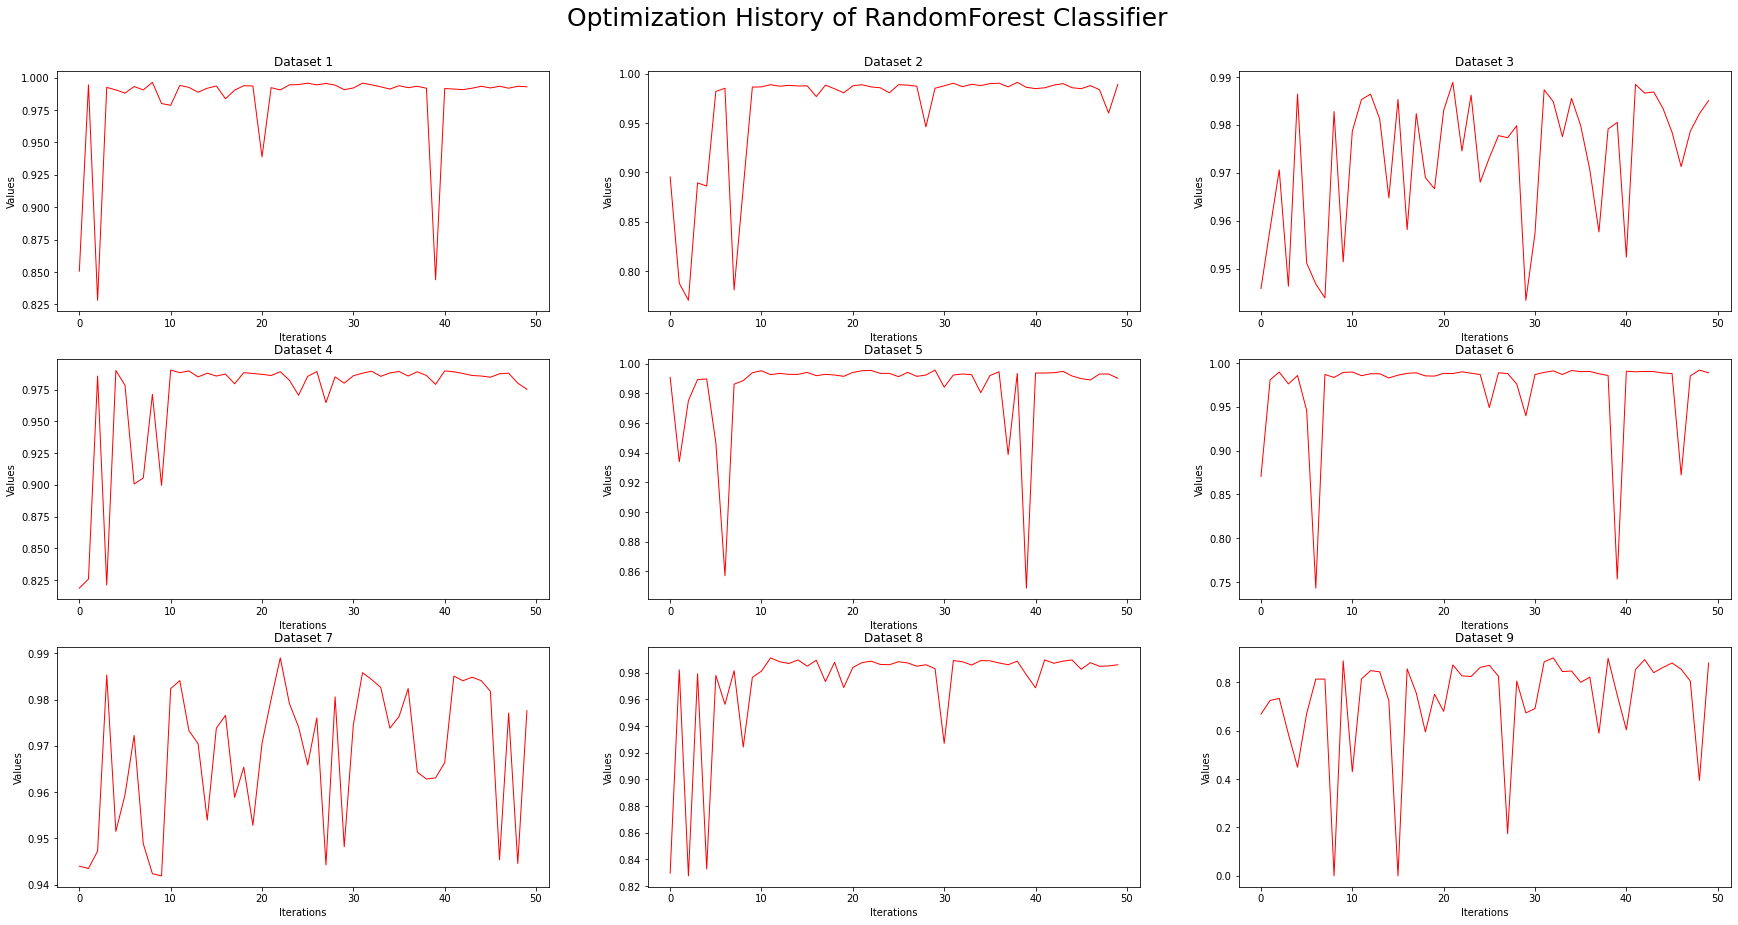

In [6]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'RandomForest Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

#### Classifier

0it [00:00, ?it/s]


 Dataset1:
Precision: 0.0010496850944716584 
Recall: 0.058823529411764705 
Aging Rate: 0.0587473534913359

 Dataset2:
Precision: 0.0011802195208308745 
Recall: 0.39215686274509803 
Aging Rate: 0.34833192871384816

 Dataset3:
Precision: 0.0011160714285714285 
Recall: 0.058823529411764705 
Aging Rate: 0.0552529342843635

 Dataset4:
Precision: 0.0008090614886731392 
Recall: 0.0196078431372549 
Aging Rate: 0.02540648317539929

 Dataset5:
Precision: 0.0021812893843916625 
Recall: 0.17647058823529413 
Aging Rate: 0.08481160969392999

 Dataset6:
Precision: 0.0013972419658586962 
Recall: 0.45098039215686275 
Aging Rate: 0.33836255627042694

 Dataset7:
Precision: 0.001182033096926714 
Recall: 0.0392156862745098 
Aging Rate: 0.03477974881292524

 Dataset8:
Precision: 0.0007380073800738007 
Recall: 0.0196078431372549 
Aging Rate: 0.027852576620279963

 Dataset9:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.029661452445065673


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


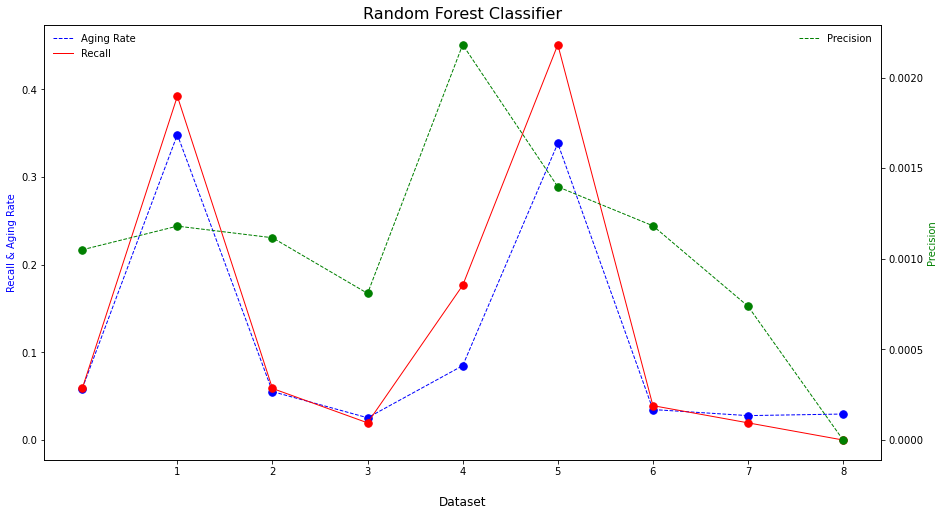

In [7]:
table_setC = runall_ForestC(run_train_x, run_test_x, run_train_y, run_test_y, best_paramC)
line_chart(table_setC, title = 'Random Forest Classifier')

In [8]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,3.0,2855.0,48.0,45743.0,0.001050,0.058824,0.058747,1.001297,0.001031,0.040811
dataset2,1.000000,2999.0,2999.0,20.0,16926.0,31.0,31672.0,0.001180,0.392157,0.348332,1.125814,0.001177,0.295747
dataset3,1.000000,3033.0,3033.0,3.0,2685.0,48.0,45913.0,0.001116,0.058824,0.055253,1.064623,0.001095,0.042644
dataset4,1.000000,3038.0,3038.0,1.0,1235.0,50.0,47363.0,0.000809,0.019608,0.025406,0.771765,0.000777,0.000000
dataset5,1.006623,3040.0,3020.0,9.0,4117.0,42.0,44481.0,0.002181,0.176471,0.084812,2.080736,0.002155,0.198559
dataset6,1.014348,3040.0,2997.0,23.0,16438.0,28.0,32160.0,0.001397,0.450980,0.338363,1.332832,0.001393,0.382018
dataset7,1.099458,3040.0,2765.0,2.0,1690.0,49.0,46908.0,0.001182,0.039216,0.034780,1.127544,0.001147,0.029607
dataset8,1.000000,3040.0,3040.0,1.0,1354.0,50.0,47244.0,0.000738,0.019608,0.027853,0.703987,0.000711,0.000000
dataset9,10.000000,3040.0,304.0,0.0,1443.0,51.0,47155.0,0.000000,0.000000,0.029661,0.000000,NaN,0.000000


#### Regressor (optional)

In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 50,
                                     filename = 'runhist_array_m2m5_4selection_RandomForest', 
                                     creator = RandomForest_creator
                                    )

In [ ]:
pr_dict, table_setR = runall_ForestR(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramR, 
                                     thres_target = 'Recall', threshold = 0.7)
line_chart(table_setR, title = 'Random Forest Regressor')

In [ ]:
multiple_curve(3, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(3, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_randomforest(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39620

 Generating Dataset 2
Size after Undersampling: 1360
Size after Undersampling: (1360, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 16:56:19,283] A new study created in memory with name: no-name-f129a640-ccda-4412-a666-79dcc32d8855


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9933598937583001 
Recall: 0.9752281616688396 
Aging Rate: 0.4908735332464146
Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
[I 2022-04-01 16:56:22,405] Trial 0 finished with value: 0.989076335953281 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 0 with value: 0.989076335953281.
Precision: 0.9986859395532195 
Recall: 0.9908735332464146 
Aging Rate: 0.49608865710560623
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
[I 2022-04-01 16:56:24,434] Trial 1 finished with value: 0.994338350215758 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 1 with value: 0.994338350215758.
Precision: 0.9973958333333334 
Recall: 0.998696219035

Precision: 0.9921363040629095 
Recall: 0.9869621903520208 
Aging Rate: 0.4973924380704042
Precision: 0.9904761904761905 
Recall: 0.9491525423728814 
Aging Rate: 0.4791395045632334
Precision: 0.9739583333333334 
Recall: 0.9752281616688396 
Aging Rate: 0.500651890482399
[I 2022-04-01 16:57:16,671] Trial 17 finished with value: 0.9778364951042168 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 1 with value: 0.994338350215758.
Precision: 0.9986859395532195 
Recall: 0.9908735332464146 
Aging Rate: 0.49608865710560623
Precision: 0.9960732984293194 
Recall: 0.9921773142112125 
Aging Rate: 0.4980443285528031
Precision: 0.9960474308300395 
Recall: 0.9856584093872229 
Aging Rate: 0.49478487614080835
[I 2022-04-01 16:57:23,015] Trial 18 finished with value: 0.9932371917339614 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 1 with value: 0.994338350215758.
Precision: 1.0 
Recall: 0.9908735332464146 
Aging R

[I 2022-04-01 16:57:35,899] A new study created in memory with name: no-name-32514821-66a0-47b0-8058-632be7c85903


Precision: 0.9895424836601308 
Recall: 0.9869621903520208 
Aging Rate: 0.49869621903520206
[I 2022-04-01 16:57:35,839] Trial 24 finished with value: 0.9906282225755317 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 19 with value: 0.9943408894097407.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9663978494623656 
Recall: 0.9625167336010709 
Aging Rate: 0.4979919678714859
Precision: 0.9690444145356663 
Recall: 0.963855421686747 
Aging Rate: 0.49732262382864795
Precision: 0.9781121751025992 
Recall: 0.9571619812583668 
Aging Rate: 0.4892904953145917
[I 2022-04-01 16:57:37,052] Trial 0 finished with value: 0.9661400068860863 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 12}. Best is trial 0 with value: 0.9661400068860863.
Precision: 0.9800531914893617 
Recall: 0.9866131191432396 
Aging Rate: 0.5033467202141901
Precision: 0.9814323607427056 
Recall: 0.9906291834002677 
Aging Rate: 0.5046854082998661
Precision: 0.988 
Recall: 0.9919678714859438 
Aging Rate: 0.5020080321285141
[I 2022-04-01 16:57:40,045] Trial 1 finished with value: 0.9864371672816564 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 1 with value: 0.9864371672816564.
Precision: 0.9688768606224628 
Recall: 0.9585006693440429 
Aging

Precision: 0.9605077574047954 
Recall: 0.9116465863453815 
Aging Rate: 0.4745649263721553
Precision: 0.9545454545454546 
Recall: 0.927710843373494 
Aging Rate: 0.4859437751004016
Precision: 0.9786931818181818 
Recall: 0.9223560910307899 
Aging Rate: 0.47121820615796517
[I 2022-04-01 16:58:28,737] Trial 17 finished with value: 0.9420220976797241 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 9}. Best is trial 12 with value: 0.9891503976174635.
Precision: 0.9866666666666667 
Recall: 0.9906291834002677 
Aging Rate: 0.5020080321285141
Precision: 0.9814814814814815 
Recall: 0.9933065595716198 
Aging Rate: 0.5060240963855421
Precision: 0.9709379128137384 
Recall: 0.9839357429718876 
Aging Rate: 0.5066934404283802
[I 2022-04-01 16:58:31,033] Trial 18 finished with value: 0.9844653958994086 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 12 with value: 0.9891503976174635.
Precision: 0.9748344370860927 
Recall: 0.9852744

[I 2022-04-01 16:58:46,048] A new study created in memory with name: no-name-7baa652e-286a-4abc-9b69-2efcf86c2ea0


Precision: 0.974934036939314 
Recall: 0.9892904953145917 
Aging Rate: 0.5073627844712182
[I 2022-04-01 16:58:46,006] Trial 24 finished with value: 0.984281400713246 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 12 with value: 0.9891503976174635.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9565789473684211 
Aging Rate: 0.47828947368421054
Precision: 0.9986091794158554 
Recall: 0.9447368421052632 
Aging Rate: 0.4730263157894737
Precision: 0.9945429740791268 
Recall: 0.9592105263157895 
Aging Rate: 0.48223684210526313
[I 2022-04-01 16:58:48,390] Trial 0 finished with value: 0.9750970784149199 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 0 with value: 0.9750970784149199.
Precision: 1.0 
Recall: 0.8842105263157894 
Aging Rate: 0.4421052631578947
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.8947368421052632 
Aging Rate: 0.4473684210526316
[I 2022-04-01 16:58:52,862] Trial 1 finished with value: 0.9449053561363329 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 0 with value: 0.9750970784149199.
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 1.0 
Re

Precision: 1.0 
Recall: 0.9355263157894737 
Aging Rate: 0.4677631578947368
Precision: 1.0 
Recall: 0.9447368421052632 
Aging Rate: 0.4723684210526316
Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
[I 2022-04-01 16:59:30,389] Trial 18 finished with value: 0.965487696341179 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 12}. Best is trial 11 with value: 0.9913764646602082.
Precision: 0.9959128065395095 
Recall: 0.9618421052631579 
Aging Rate: 0.48289473684210527
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
Precision: 1.0 
Recall: 0.9592105263157895 
Aging Rate: 0.47960526315789476
[I 2022-04-01 16:59:32,460] Trial 19 finished with value: 0.9803538606629183 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 11 with value: 0.9913764646602082.
Precision: 0.9972222222222222 
Recall: 0.9447368421052632 
Aging Rate: 0.47368421052631576
Precision: 0.997

[I 2022-04-01 16:59:42,000] A new study created in memory with name: no-name-8a3dc684-35e1-4ee9-a791-0a3e2f26de65


Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2022-04-01 16:59:41,947] Trial 24 finished with value: 0.9851106257394333 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 11 with value: 0.9913764646602082.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9959677419354839 
Recall: 0.975 
Aging Rate: 0.48947368421052634
Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2022-04-01 16:59:43,021] Trial 0 finished with value: 0.9855778726235472 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 15}. Best is trial 0 with value: 0.9855778726235472.
Precision: 0.9946236559139785 
Recall: 0.9736842105263158 
Aging Rate: 0.48947368421052634
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
[I 2022-04-01 16:59:45,064] Trial 1 finished with value: 0.988927798162509 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 1 with value: 0.988927798162509.
Precision: 0.9971751412429378 
Recall: 0.9289473684210526 
Aging Rate: 0.46578947368421053
Prec

Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
[I 2022-04-01 17:00:28,639] Trial 17 finished with value: 0.9916028502934165 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 10 with value: 0.9922846125877537.
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
[I 2022-04-01 17:00:30,771] Trial 18 finished with value: 0.9887343947266275 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 10 with value: 0.9922846125877537.
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314

[I 2022-04-01 17:00:44,214] A new study created in memory with name: no-name-98c085b1-0dd4-46c4-8d30-0004b890f240


Precision: 0.9905660377358491 
Recall: 0.9671052631578947 
Aging Rate: 0.4881578947368421
[I 2022-04-01 17:00:44,163] Trial 24 finished with value: 0.9747713923629998 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 10 with value: 0.9922846125877537.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9375 
Recall: 0.9139072847682119 
Aging Rate: 0.4858085808580858
Precision: 0.9325236167341431 
Recall: 0.9152317880794701 
Aging Rate: 0.4891089108910891
Precision: 0.9479305740987984 
Recall: 0.9403973509933775 
Aging Rate: 0.49438943894389437
[I 2022-04-01 17:00:49,479] Trial 0 finished with value: 0.93116634917786 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 0 with value: 0.93116634917786.
Precision: 0.9826666666666667 
Recall: 0.976158940397351 
Aging Rate: 0.49504950495049505
Precision: 0.9892183288409704 
Recall: 0.9721854304635762 
Aging Rate: 0.4897689768976898
Precision: 0.9876543209876543 
Recall: 0.9536423841059603 
Aging Rate: 0.48118811881188117
[I 2022-04-01 17:00:51,509] Trial 1 finished with value: 0.9767934400599466 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 1 with value: 0.9767934400599466.
Precision: 0.9973045822102425 
Recall: 0.9801324503311258 
Aging R

Precision: 0.9959946595460614 
Recall: 0.9880794701986755 
Aging Rate: 0.49438943894389437
Precision: 0.9946236559139785 
Recall: 0.9801324503311258 
Aging Rate: 0.4910891089108911
Precision: 0.9880794701986755 
Recall: 0.9880794701986755 
Aging Rate: 0.49834983498349833
[I 2022-04-01 17:01:44,958] Trial 17 finished with value: 0.9891418766833079 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 15 with value: 0.9942440248910209.
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
Precision: 0.9829619921363041 
Recall: 0.9933774834437086 
Aging Rate: 0.5036303630363036
[I 2022-04-01 17:01:45,814] Trial 18 finished with value: 0.9894249113692618 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 15 with value: 0.9942440248910209.
Precision: 0.9959893048128342 
Recall: 0.98675

[I 2022-04-01 17:01:51,613] A new study created in memory with name: no-name-1f49507e-8698-4125-b247-1456f5f6971d


Precision: 1.0 
Recall: 0.9774834437086093 
Aging Rate: 0.4871287128712871
[I 2022-04-01 17:01:51,569] Trial 24 finished with value: 0.990683537260996 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 15}. Best is trial 15 with value: 0.9942440248910209.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9798387096774194 
Recall: 0.9745989304812834 
Aging Rate: 0.493368700265252
Precision: 0.9931787175989086 
Recall: 0.9732620320855615 
Aging Rate: 0.4860742705570292
Precision: 0.9852150537634409 
Recall: 0.9799465240641712 
Aging Rate: 0.493368700265252
[I 2022-04-01 17:01:53,848] Trial 0 finished with value: 0.9809683455434008 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 0 with value: 0.9809683455434008.
Precision: 0.8050847457627118 
Recall: 0.6350267379679144 
Aging Rate: 0.3912466843501326
Precision: 0.8224 
Recall: 0.6871657754010695 
Aging Rate: 0.41445623342175064
Precision: 0.8074433656957929 
Recall: 0.6671122994652406 
Aging Rate: 0.40981432360742703
[I 2022-04-01 17:01:55,550] Trial 1 finished with value: 0.7297802197666154 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 3}. Best is trial 0 with value: 0.9809683455434008.
Precision: 0.9852744310575636 
Recall: 0.983957219251337 
Aging 

Precision: 0.9854304635761589 
Recall: 0.9946524064171123 
Aging Rate: 0.5006631299734748
Precision: 0.9814323607427056 
Recall: 0.9893048128342246 
Aging Rate: 0.5
[I 2022-04-01 17:02:42,700] Trial 17 finished with value: 0.9882401198490723 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 8 with value: 0.9915891799983149.
Precision: 0.9813829787234043 
Recall: 0.9866310160427807 
Aging Rate: 0.4986737400530504
Precision: 0.9866666666666667 
Recall: 0.9893048128342246 
Aging Rate: 0.4973474801061008
Precision: 0.9802371541501976 
Recall: 0.9946524064171123 
Aging Rate: 0.503315649867374
[I 2022-04-01 17:02:44,383] Trial 18 finished with value: 0.9864587161707018 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 8 with value: 0.9915891799983149.
Precision: 0.9656084656084656 
Recall: 0.9759358288770054 
Aging Rate: 0.5013262599469496
Precision: 0.9826897470039947 
Recall: 0.9866310160427807 
Aging R

[I 2022-04-01 17:03:18,133] A new study created in memory with name: no-name-f9f06428-570e-4393-add8-cc042dd34f3d


Precision: 0.9787798408488063 
Recall: 0.9866310160427807 
Aging Rate: 0.5
[I 2022-04-01 17:03:18,073] Trial 24 finished with value: 0.9869032356946117 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 8 with value: 0.9915891799983149.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
Precision: 1.0 
Recall: 0.9605263157894737 
Aging Rate: 0.48026315789473684
Precision: 0.9986149584487535 
Recall: 0.9486842105263158 
Aging Rate: 0.475
[I 2022-04-01 17:03:21,078] Trial 0 finished with value: 0.9766650010541781 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 0 with value: 0.9766650010541781.
Precision: 1.0 
Recall: 0.906578947368421 
Aging Rate: 0.4532894736842105
Precision: 1.0 
Recall: 0.8881578947368421 
Aging Rate: 0.4440789473684211
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
[I 2022-04-01 17:03:22,328] Trial 1 finished with value: 0.94613539576424 and parameters: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 9}. Best is trial 0 with value: 0.9766650010541781.
Precision: 1.0 
Recall: 0.8907894736842106 
Aging Rate: 0.4453947368421053
Precision: 1.0 
Recall: 0.9026315789473685 
Aging Rate: 0.4513157894

Precision: 1.0 
Recall: 0.9381578947368421 
Aging Rate: 0.46907894736842104
Precision: 1.0 
Recall: 0.9407894736842105 
Aging Rate: 0.47039473684210525
Precision: 0.9986206896551724 
Recall: 0.9526315789473684 
Aging Rate: 0.4769736842105263
[I 2022-04-01 17:04:20,158] Trial 19 finished with value: 0.9708893430296769 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 13 with value: 0.9835252552699562.
Precision: 0.9986522911051213 
Recall: 0.975 
Aging Rate: 0.4881578947368421
Precision: 1.0 
Recall: 0.9644736842105263 
Aging Rate: 0.48223684210526313
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.4842105263157895
[I 2022-04-01 17:04:22,290] Trial 20 finished with value: 0.9841857487285767 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 20 with value: 0.9841857487285767.
Precision: 1.0 
Recall: 0.9513157894736842 
Aging Rate: 0.4756578947368421
Precision: 0.998661311914324 
Recall: 0.981

[I 2022-04-01 17:04:31,035] A new study created in memory with name: no-name-a93dac8a-d202-4df5-917d-f01039fe9690


Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
[I 2022-04-01 17:04:30,972] Trial 24 finished with value: 0.9830477080868502 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 23 with value: 0.9855285355119272.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8474341192787794 
Recall: 0.8039473684210526 
Aging Rate: 0.4743421052631579
Precision: 0.8260292164674635 
Recall: 0.8184210526315789 
Aging Rate: 0.4953947368421053
Precision: 0.8595271210013908 
Recall: 0.8131578947368421 
Aging Rate: 0.4730263157894737
[I 2022-04-01 17:04:36,674] Trial 0 finished with value: 0.8276751650875408 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.8276751650875408.
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
[I 2022-04-01 17:04:38,918] Trial 1 finished with value: 0.9904952359750997 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 1 with value: 0.9904952359750997.
Precision: 0.9851752021563343 
Recall: 0.9618421052631579 
Aging 

Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
[I 2022-04-01 17:05:21,389] Trial 17 finished with value: 0.9885033619325333 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9904961507642827.
Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
[I 2022-04-01 17:05:23,137] Trial 18 finished with value: 0.9875979868537073 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 10 with value: 0.9904961507642827.
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9959677419354839 
Recall: 0.975

[I 2022-04-01 17:05:33,737] A new study created in memory with name: no-name-83612b78-76c9-4e78-a43c-5e81a754a12f


Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-04-01 17:05:33,675] Trial 24 finished with value: 0.9895953576725042 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 10 with value: 0.9904961507642827.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:05:36,279] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 0 with value: 0.0.
Precision: 0.9473684210526315 
Recall: 0.47368421052631576 
Aging Rate: 0.045454545454545456
Precision: 0.9743589743589743 
Recall: 0.5 
Aging Rate: 0.04665071770334928
Precision: 0.9722222222222222 
Recall: 0.4605263157894737 
Aging Rate: 0.0430622009569378
[I 2022-04-01 17:05:40,791] Trial 1 finished with value: 0.6391495041952707 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 1 with value: 0.6391495041952707.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:05:41,657] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 1 with value: 0.6391495041952707.
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
[I 2022-04-01 17:05:43,894] Trial 3 finished with value: 0.10781893004115227 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 1 with value: 0.6391495041952707.
Precision: 1.0 
Recall: 0.7368421052631579 
Aging Rate: 0.06698564593301436
Precision: 1.0 
Recall: 0.5921052631578947 
Aging Rate: 0.05382775119617225
Precision: 1.0 
Recall: 0.6578947368421053 
Aging Rate: 0.05980861244019139
[I 2022-04-01 17:05:46,410] Trial 4 finished with value: 0.7953124316760679 and parameters: {'n_estimat

Precision: 1.0 
Recall: 0.7894736842105263 
Aging Rate: 0.07177033492822966
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 1.0 
Recall: 0.75 
Aging Rate: 0.06818181818181818
[I 2022-04-01 17:06:17,807] Trial 21 finished with value: 0.8711899574644674 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 17 with value: 0.8735327741009004.
Precision: 0.984375 
Recall: 0.8289473684210527 
Aging Rate: 0.07655502392344497
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
Precision: 1.0 
Recall: 0.7763157894736842 
Aging Rate: 0.07057416267942583
[I 2022-04-01 17:06:19,471] Trial 22 finished with value: 0.8827160493827161 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 22 with value: 0.8827160493827161.
Precision: 0.9672131147540983 
Recall: 0.7763157894736842 
Aging Rate: 0.0729665071770335
Precision: 1.0 
Recall: 0.6842105263157895 
Aging R

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39620

 Generating Dataset 2
Size after Undersampling: 1360
Size after Undersampling: (1360, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 17:07:56,949] A new study created in memory with name: no-name-ebe6a805-7eda-4cb5-bd3e-c8efa016f0cb


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9572763684913218 
Recall: 0.9348109517601043 
Aging Rate: 0.48826597131681876
Precision: 0.9380764163372859 
Recall: 0.9282920469361148 
Aging Rate: 0.49478487614080835
Precision: 0.9586666666666667 
Recall: 0.9374185136897001 
Aging Rate: 0.48891786179921776
[I 2022-04-01 17:07:57,802] Trial 0 finished with value: 0.942330802687195 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 6}. Best is trial 0 with value: 0.942330802687195.
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9973718791064389 
Recall: 0.9895697522816167 
Aging Rate: 0.49608865710560623
[I 2022-04-01 17:08:02,672] Trial 1 finished with value: 0.9923697387061466 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 1 with value: 0.9923697387061466.
Precision: 0.9960681520314548 
Recall: 0.99087353

Precision: 0.996078431372549 
Recall: 0.9934810951760105 
Aging Rate: 0.49869621903520206
Precision: 0.9973718791064389 
Recall: 0.9895697522816167 
Aging Rate: 0.49608865710560623
Precision: 0.9986842105263158 
Recall: 0.9895697522816167 
Aging Rate: 0.4954367666232073
[I 2022-04-01 17:08:40,121] Trial 17 finished with value: 0.9941132185468659 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 14 with value: 0.996087523136513.
Precision: 0.9947848761408083 
Recall: 0.9947848761408083 
Aging Rate: 0.5
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
[I 2022-04-01 17:08:40,973] Trial 18 finished with value: 0.9926016880662084 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 14 with value: 0.996087523136513.
Precision: 0.9830065359477124 
Recall: 0.9804432855280313 
Agin

[I 2022-04-01 17:08:48,298] A new study created in memory with name: no-name-0139ba47-7be6-4850-87c1-afe3794efb89


Precision: 0.9896373056994818 
Recall: 0.9960886571056062 
Aging Rate: 0.5032594524119948
[I 2022-04-01 17:08:48,254] Trial 24 finished with value: 0.9902203188671269 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 14 with value: 0.996087523136513.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8943661971830986 
Recall: 0.8477970627503337 
Aging Rate: 0.4739652870493992
Precision: 0.9092198581560283 
Recall: 0.855807743658211 
Aging Rate: 0.4706275033377837
Precision: 0.9121338912133892 
Recall: 0.8731642189586115 
Aging Rate: 0.4786381842456609
[I 2022-04-01 17:08:50,833] Trial 0 finished with value: 0.8814628654401725 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.8814628654401725.
Precision: 0.986737400530504 
Recall: 0.9933244325767691 
Aging Rate: 0.5033377837116155
Precision: 0.9866666666666667 
Recall: 0.9879839786381842 
Aging Rate: 0.5006675567423231
Precision: 0.9840213049267643 
Recall: 0.986648865153538 
Aging Rate: 0.5013351134846462
[I 2022-04-01 17:08:53,355] Trial 1 finished with value: 0.9875593922228925 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 1 with value: 0.9875593922228925.
Precision: 0.9840848806366048 
Recall: 0.99065420560747

Precision: 0.9813829787234043 
Recall: 0.9853137516688919 
Aging Rate: 0.5020026702269693
Precision: 0.9815303430079155 
Recall: 0.9933244325767691 
Aging Rate: 0.5060080106809078
Precision: 0.9893617021276596 
Recall: 0.9933244325767691 
Aging Rate: 0.5020026702269693
[I 2022-04-01 17:09:33,109] Trial 17 finished with value: 0.9873585713925731 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 12 with value: 0.9904576064618803.
Precision: 0.9788359788359788 
Recall: 0.9879839786381842 
Aging Rate: 0.5046728971962616
Precision: 0.9813333333333333 
Recall: 0.9826435246995995 
Aging Rate: 0.5006675567423231
Precision: 0.9839786381842457 
Recall: 0.9839786381842457 
Aging Rate: 0.5
[I 2022-04-01 17:09:38,299] Trial 18 finished with value: 0.983118444832615 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 12 with value: 0.9904576064618803.
Precision: 0.9867197875166003 
Recall: 0.9919893190921228 
Ag

[I 2022-04-01 17:09:55,192] A new study created in memory with name: no-name-7ffca5bf-063b-42ac-b226-e2f3c85460df


Precision: 0.9853528628495339 
Recall: 0.9879839786381842 
Aging Rate: 0.5013351134846462
[I 2022-04-01 17:09:55,136] Trial 24 finished with value: 0.9877766999720482 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 18}. Best is trial 20 with value: 0.9913461888393917.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.997179125528914 
Recall: 0.9302631578947368 
Aging Rate: 0.4664473684210526
Precision: 0.9971711456859972 
Recall: 0.9276315789473685 
Aging Rate: 0.4651315789473684
Precision: 0.9985775248933144 
Recall: 0.9236842105263158 
Aging Rate: 0.4625
[I 2022-04-01 17:09:56,867] Trial 0 finished with value: 0.9611255552146108 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 12}. Best is trial 0 with value: 0.9611255552146108.
Precision: 0.998546511627907 
Recall: 0.9039473684210526 
Aging Rate: 0.45263157894736844
Precision: 0.9985795454545454 
Recall: 0.925 
Aging Rate: 0.4631578947368421
Precision: 0.9985775248933144 
Recall: 0.9236842105263158 
Aging Rate: 0.4625
[I 2022-04-01 17:09:59,251] Trial 1 finished with value: 0.9563164827752798 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.9611255552146108.
Precision: 1.0 
Recall: 0.8842105263157894 
Aging Rate: 0.4421052631578947
Precision: 1.0 

Precision: 0.9985955056179775 
Recall: 0.9355263157894737 
Aging Rate: 0.46842105263157896
Precision: 1.0 
Recall: 0.9157894736842105 
Aging Rate: 0.45789473684210524
Precision: 0.9972260748959778 
Recall: 0.9460526315789474 
Aging Rate: 0.4743421052631579
[I 2022-04-01 17:10:40,043] Trial 18 finished with value: 0.9643473761826152 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 15 with value: 0.974138185396218.
Precision: 0.9986013986013986 
Recall: 0.9394736842105263 
Aging Rate: 0.47039473684210525
Precision: 0.9985835694050992 
Recall: 0.9276315789473685 
Aging Rate: 0.4644736842105263
Precision: 0.99721059972106 
Recall: 0.9407894736842105 
Aging Rate: 0.47171052631578947
[I 2022-04-01 17:10:42,685] Trial 19 finished with value: 0.9660383841549388 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 15}. Best is trial 15 with value: 0.974138185396218.
Precision: 0.9958333333333333 
Recall: 0.9434210526315789 
Agi

[I 2022-04-01 17:10:47,576] A new study created in memory with name: no-name-948b7b7f-2888-4e57-a8df-993f8ccf46f6


Precision: 0.9985955056179775 
Recall: 0.9355263157894737 
Aging Rate: 0.46842105263157896
[I 2022-04-01 17:10:47,521] Trial 24 finished with value: 0.9702427570498621 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 15}. Best is trial 23 with value: 0.9792259548209851.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986225895316805 
Recall: 0.9539473684210527 
Aging Rate: 0.4776315789473684
Precision: 0.9972677595628415 
Recall: 0.9605263157894737 
Aging Rate: 0.48157894736842105
Precision: 0.9959349593495935 
Recall: 0.9671052631578947 
Aging Rate: 0.4855263157894737
[I 2022-04-01 17:10:48,444] Trial 0 finished with value: 0.9785448598906457 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 0 with value: 0.9785448598906457.
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2022-04-01 17:10:50,177] Trial 1 finished with value: 0.988926340847696 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 1 with value: 0.988926340847696.
Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
Precision: 0.997

Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-04-01 17:11:27,626] Trial 17 finished with value: 0.9857996225904769 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 15}. Best is trial 10 with value: 0.9893796418735104.
Precision: 0.997289972899729 
Recall: 0.968421052631579 
Aging Rate: 0.4855263157894737
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
[I 2022-04-01 17:11:29,597] Trial 18 finished with value: 0.9839966565090797 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 12}. Best is trial 10 with value: 0.9893796418735104.
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.9959514170040485 
Recall: 0.971052

[I 2022-04-01 17:11:45,474] A new study created in memory with name: no-name-c354d3cf-acd3-40d1-9a23-d4043927e9d4


Precision: 0.9959623149394348 
Recall: 0.9736842105263158 
Aging Rate: 0.4888157894736842
[I 2022-04-01 17:11:45,412] Trial 24 finished with value: 0.9889436301638227 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 10 with value: 0.9893796418735104.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 0.9894039735099338 
Recall: 0.9894039735099338 
Aging Rate: 0.49834983498349833
Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
[I 2022-04-01 17:11:47,511] Trial 0 finished with value: 0.9927101046687111 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 0 with value: 0.9927101046687111.
Precision: 0.99734395750332 
Recall: 0.9947019867549669 
Aging Rate: 0.497029702970297
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 0.9973297730307076 
Recall: 0.9894039735099338 
Aging Rate: 0.49438943894389437
[I 2022-04-01 17:11:50,523] Trial 1 finished with value: 0.9951294067479729 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 1 with value: 0.9951294067479729.
Precision: 0.9894459102902374 
Recall: 0.9933774834437

Precision: 0.9986666666666667 
Recall: 0.9920529801324504 
Aging Rate: 0.49504950495049505
Precision: 0.9986702127659575 
Recall: 0.9947019867549669 
Aging Rate: 0.49636963696369635
Precision: 0.9986702127659575 
Recall: 0.9947019867549669 
Aging Rate: 0.49636963696369635
[I 2022-04-01 17:12:34,094] Trial 17 finished with value: 0.9962377123809819 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 17 with value: 0.9962377123809819.
Precision: 0.9986666666666667 
Recall: 0.9920529801324504 
Aging Rate: 0.49504950495049505
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
Precision: 0.9986702127659575 
Recall: 0.9947019867549669 
Aging Rate: 0.49636963696369635
[I 2022-04-01 17:12:36,952] Trial 18 finished with value: 0.9955729673942547 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 17 with value: 0.9962377123809819.
Precision: 1.0 
Recall: 0.9880794701986755 

[I 2022-04-01 17:12:54,036] A new study created in memory with name: no-name-2ad87d26-c7cc-4a0a-b7f2-907795656e89


Precision: 0.9920948616600791 
Recall: 0.9973509933774835 
Aging Rate: 0.500990099009901
[I 2022-04-01 17:12:53,973] Trial 24 finished with value: 0.9924967443342047 and parameters: {'n_estimators': 500, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 17 with value: 0.9962377123809819.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9592641261498029 
Recall: 0.9759358288770054 
Aging Rate: 0.5046419098143236
Precision: 0.9696169088507266 
Recall: 0.9812834224598931 
Aging Rate: 0.5019893899204244
Precision: 0.9795081967213115 
Recall: 0.9585561497326203 
Aging Rate: 0.4854111405835544
[I 2022-04-01 17:12:59,131] Trial 0 finished with value: 0.9706207885527318 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 0 with value: 0.9706207885527318.
Precision: 0.9666666666666667 
Recall: 0.93048128342246 
Aging Rate: 0.47745358090185674
Precision: 0.9634831460674157 
Recall: 0.9171122994652406 
Aging Rate: 0.47214854111405835
Precision: 0.9608391608391609 
Recall: 0.9184491978609626 
Aging Rate: 0.47413793103448276
[I 2022-04-01 17:13:00,987] Trial 1 finished with value: 0.9423736690972938 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 9}. Best is trial 0 with value: 0.9706207885527318.
Precision: 0.9825503355704698 
Recall: 0.97860962

Precision: 0.988 
Recall: 0.9906417112299465 
Aging Rate: 0.4973474801061008
Precision: 0.9698162729658792 
Recall: 0.9879679144385026 
Aging Rate: 0.5053050397877984
Precision: 0.9866844207723036 
Recall: 0.9906417112299465 
Aging Rate: 0.4980106100795756
[I 2022-04-01 17:14:00,947] Trial 17 finished with value: 0.9855953817378039 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 11 with value: 0.9908899252350286.
Precision: 0.9828269484808454 
Recall: 0.9946524064171123 
Aging Rate: 0.5019893899204244
Precision: 0.9813829787234043 
Recall: 0.9866310160427807 
Aging Rate: 0.4986737400530504
Precision: 0.9814569536423841 
Recall: 0.9906417112299465 
Aging Rate: 0.5006631299734748
[I 2022-04-01 17:14:06,283] Trial 18 finished with value: 0.9862440876828845 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 11 with value: 0.9908899252350286.
Precision: 0.975 
Recall: 0.9906417112299465 
Aging Rate: 0

[I 2022-04-01 17:14:32,108] A new study created in memory with name: no-name-0a08768a-5d43-4cee-872c-1f58f074244d


Precision: 0.9893333333333333 
Recall: 0.9919786096256684 
Aging Rate: 0.4973474801061008
[I 2022-04-01 17:14:32,045] Trial 24 finished with value: 0.9862797153874326 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 11 with value: 0.9908899252350286.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.998589562764457 
Recall: 0.9315789473684211 
Aging Rate: 0.4664473684210526
Precision: 0.9985935302390999 
Recall: 0.9342105263157895 
Aging Rate: 0.4677631578947368
Precision: 0.994475138121547 
Recall: 0.9473684210526315 
Aging Rate: 0.4763157894736842
[I 2022-04-01 17:14:37,286] Trial 0 finished with value: 0.9665337155706708 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 18}. Best is trial 0 with value: 0.9665337155706708.
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recall: 0.8986842105263158 
Aging Rate: 0.4493421052631579
[I 2022-04-01 17:14:39,143] Trial 1 finished with value: 0.9502698910431985 and parameters: {'n_estimators': 300, 'min_samples_split': 6, 'max_depth': 6}. Best is trial 0 with value: 0.9665337155706708.
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recal

Precision: 0.9986033519553073 
Recall: 0.9407894736842105 
Aging Rate: 0.4710526315789474
Precision: 0.9958677685950413 
Recall: 0.9513157894736842 
Aging Rate: 0.4776315789473684
[I 2022-04-01 17:15:44,519] Trial 18 finished with value: 0.9723336543424299 and parameters: {'n_estimators': 500, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 12 with value: 0.9782669225348034.
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
Precision: 1.0 
Recall: 0.9 
Aging Rate: 0.45
Precision: 1.0 
Recall: 0.9013157894736842 
Aging Rate: 0.4506578947368421
[I 2022-04-01 17:15:46,214] Trial 19 finished with value: 0.9502639224489601 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 12 with value: 0.9782669225348034.
Precision: 1.0 
Recall: 0.9486842105263158 
Aging Rate: 0.4743421052631579
Precision: 1.0 
Recall: 0.9473684210526315 
Aging Rate: 0.47368421052631576
Precision: 0.9972714870395635 
Recall: 0.9618421052631579 


[I 2022-04-01 17:16:13,371] A new study created in memory with name: no-name-8568bebd-fbd5-4252-8c65-96f064c0234a


Precision: 1.0 
Recall: 0.9460526315789474 
Aging Rate: 0.4730263157894737
[I 2022-04-01 17:16:13,307] Trial 24 finished with value: 0.9800592955150732 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 24 with value: 0.9800592955150732.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.929778933680104 
Recall: 0.9407894736842105 
Aging Rate: 0.5059210526315789
Precision: 0.9337748344370861 
Recall: 0.9276315789473685 
Aging Rate: 0.4967105263157895
Precision: 0.9234828496042217 
Recall: 0.9210526315789473 
Aging Rate: 0.4986842105263158
[I 2022-04-01 17:16:16,001] Trial 0 finished with value: 0.9294036691751751 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 0 with value: 0.9294036691751751.
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
[I 2022-04-01 17:16:17,031] Trial 1 finished with value: 0.9873609536666029 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 1 with value: 0.9873609536666029.
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.484868

Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-04-01 17:16:50,985] Trial 17 finished with value: 0.9871281423879804 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 11 with value: 0.9898158301856398.
Precision: 1.0 
Recall: 0.9671052631578947 
Aging Rate: 0.48355263157894735
Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
[I 2022-04-01 17:16:52,137] Trial 18 finished with value: 0.9841946391996949 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 18}. Best is trial 11 with value: 0.9898158301856398.
Precision: 0.998641304347826 
Recall: 0.9671052631578947 
Aging Rate: 0.4842105263157895
Precision: 0.998641304347826 
Recall: 0.9671052631578947 
Aging Rate: 0.4842105263157895
Precision: 0.9986338797814208 
Recall: 0.9618421052631579 
Agi

[I 2022-04-01 17:17:00,718] A new study created in memory with name: no-name-1493f79d-4f83-4972-aeee-75f74cd983d8


Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
[I 2022-04-01 17:17:00,671] Trial 24 finished with value: 0.9869002550367566 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 11 with value: 0.9898158301856398.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.23684210526315788 
Aging Rate: 0.0215311004784689
Precision: 1.0 
Recall: 0.18421052631578946 
Aging Rate: 0.01674641148325359
Precision: 1.0 
Recall: 0.15789473684210525 
Aging Rate: 0.014354066985645933
[I 2022-04-01 17:17:01,732] Trial 0 finished with value: 0.3222723690808797 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 0 with value: 0.3222723690808797.
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
[I 2022-04-01 17:17:03,469] Trial 1 finished with value: 0.10781893004115224 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 6}. Best is trial 0 with value: 0.3222723690808797.
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 1.0 
Recall: 0.06578947368421052 
Agin

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:17:20,086] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 3}. Best is trial 3 with value: 0.9115805946791863.
Precision: 1.0 
Recall: 0.18421052631578946 
Aging Rate: 0.01674641148325359
Precision: 1.0 
Recall: 0.21052631578947367 
Aging Rate: 0.019138755980861243
Precision: 1.0 
Recall: 0.14473684210526316 
Aging Rate: 0.013157894736842105
[I 2022-04-01 17:17:21,820] Trial 8 finished with value: 0.30393692042867454 and parameters: {'n_estimators': 300, 'min_samples_split': 12, 'max_depth': 9}. Best is trial 3 with value: 0.9115805946791863.
Precision: 1.0 
Recall: 0.4868421052631579 
Aging Rate: 0.04425837320574163
Precision: 1.0 
Recall: 0.5526315789473685 
Aging Rate: 0.050239234449760764
Precision: 0.9512195121951219 
Recall: 0.5131578947368421 
Aging Rate: 0.04904306220095694
[I 2022-04-01 17:17:23,546] Trial 9 finished with value: 0.6777994433611653 and parame

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39629

 Generating Dataset 2
Size after Undersampling: 1378
Size after Undersampling: (1378, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-04-01 17:19:38,862] A new study created in memory with name: no-name-e0f12803-caec-4d6f-b5c3-d40db77dd448


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9869791666666666 
Recall: 0.9882659713168188 
Aging Rate: 0.500651890482399
Precision: 0.9960681520314548 
Recall: 0.9908735332464146 
Aging Rate: 0.4973924380704042
[I 2022-04-01 17:19:44,150] Trial 0 finished with value: 0.9913098010552348 and parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'max_depth': 15}. Best is trial 0 with value: 0.9913098010552348.
Precision: 0.9562913907284768 
Recall: 0.9413298565840938 
Aging Rate: 0.4921773142112125
Precision: 0.9491525423728814 
Recall: 0.9491525423728814 
Aging Rate: 0.5
Precision: 0.951885565669701 
Recall: 0.954367666232073 
Aging Rate: 0.5013037809647979
[I 2022-04-01 17:19:46,048] Trial 1 finished with value: 0.9503430616494799 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 0 with value: 0.9913098010552348.
Precision: 0.9386422976501305 
Recall: 0.9374185136897001 
Aging Rate

Precision: 0.9934296977660972 
Recall: 0.9856584093872229 
Aging Rate: 0.49608865710560623
Precision: 0.9882506527415144 
Recall: 0.9869621903520208 
Aging Rate: 0.49934810951760106
Precision: 0.9868593955321945 
Recall: 0.9791395045632334 
Aging Rate: 0.49608865710560623
[I 2022-04-01 17:20:20,816] Trial 17 finished with value: 0.9867063634366223 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 12}. Best is trial 14 with value: 0.9960826865341499.
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
Precision: 0.9921465968586387 
Recall: 0.9882659713168188 
Aging Rate: 0.4980443285528031
[I 2022-04-01 17:20:21,945] Trial 18 finished with value: 0.9904233150805574 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 12}. Best is trial 14 with value: 0.9960826865341499.
Precision: 0.9921875 
Recall: 0.9934810951760105 
Aging Rat

[I 2022-04-01 17:20:31,802] A new study created in memory with name: no-name-3117bcce-1bea-4e0c-8526-cb6a441793cf


Precision: 0.9908616187989556 
Recall: 0.9895697522816167 
Aging Rate: 0.49934810951760106
[I 2022-04-01 17:20:31,758] Trial 24 finished with value: 0.9915087887475323 and parameters: {'n_estimators': 100, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 14 with value: 0.9960826865341499.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8896551724137931 
Recall: 0.8588548601864181 
Aging Rate: 0.4826897470039947
Precision: 0.9056865464632455 
Recall: 0.8695073235685752 
Aging Rate: 0.4800266311584554
Precision: 0.8651226158038147 
Recall: 0.8455392809587217 
Aging Rate: 0.48868175765645805
[I 2022-04-01 17:20:33,647] Trial 0 finished with value: 0.8721436186419397 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 6}. Best is trial 0 with value: 0.8721436186419397.
Precision: 0.9881266490765171 
Recall: 0.9973368841544608 
Aging Rate: 0.5046604527296937
Precision: 0.9828269484808454 
Recall: 0.9906790945406125 
Aging Rate: 0.503994673768309
Precision: 0.9829396325459318 
Recall: 0.9973368841544608 
Aging Rate: 0.507323568575233
[I 2022-04-01 17:20:35,567] Trial 1 finished with value: 0.9898445755936588 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 1 with value: 0.9898445755936588.
Precision: 0.9879839786381842 
Recall: 0.9853528628495

Precision: 0.9775429326287979 
Recall: 0.9853528628495339 
Aging Rate: 0.503994673768309
Precision: 0.9724409448818898 
Recall: 0.9866844207723036 
Aging Rate: 0.507323568575233
Precision: 0.978891820580475 
Recall: 0.9880159786950732 
Aging Rate: 0.5046604527296937
[I 2022-04-01 17:21:16,912] Trial 17 finished with value: 0.9814586677134525 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 15}. Best is trial 3 with value: 0.9913668279189345.
Precision: 0.9893617021276596 
Recall: 0.9906790945406125 
Aging Rate: 0.5006657789613849
Precision: 0.9828042328042328 
Recall: 0.9893475366178429 
Aging Rate: 0.5033288948069241
Precision: 0.9920634920634921 
Recall: 0.9986684420772304 
Aging Rate: 0.5033288948069241
[I 2022-04-01 17:21:19,116] Trial 18 finished with value: 0.9904799999646802 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 3 with value: 0.9913668279189345.
Precision: 0.9828269484808454 
Recall: 0.99067909454

[I 2022-04-01 17:21:35,766] A new study created in memory with name: no-name-795f0f56-a1cc-49a3-815e-913303302ac5


Precision: 0.9700520833333334 
Recall: 0.9920106524633822 
Aging Rate: 0.511318242343542
[I 2022-04-01 17:21:35,719] Trial 24 finished with value: 0.9814638794988819 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 3 with value: 0.9913668279189345.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9421052631578948 
Aging Rate: 0.4710526315789474
Precision: 1.0 
Recall: 0.9407894736842105 
Aging Rate: 0.47039473684210525
Precision: 1.0 
Recall: 0.9302631578947368 
Aging Rate: 0.4651315789473684
[I 2022-04-01 17:21:41,283] Trial 0 finished with value: 0.9678510248760593 and parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'max_depth': 15}. Best is trial 0 with value: 0.9678510248760593.
Precision: 1.0 
Recall: 0.9368421052631579 
Aging Rate: 0.46842105263157896
Precision: 1.0 
Recall: 0.9092105263157895 
Aging Rate: 0.45460526315789473
Precision: 1.0 
Recall: 0.9263157894736842 
Aging Rate: 0.4631578947368421
[I 2022-04-01 17:21:46,683] Trial 1 finished with value: 0.9605288422624071 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 12}. Best is trial 0 with value: 0.9678510248760593.
Precision: 1.0 
Recall: 0.9486842105263158 
Aging Rate: 0.4743421052631579
Precision: 1.0 
Recall: 0.9631578947368421 
Aging Rate: 0.4815

Precision: 1.0 
Recall: 0.9565789473684211 
Aging Rate: 0.47828947368421054
Precision: 1.0 
Recall: 0.9644736842105263 
Aging Rate: 0.48223684210526313
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
[I 2022-04-01 17:22:25,551] Trial 19 finished with value: 0.9789476857537961 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 7 with value: 0.9871155383991486.
Precision: 1.0 
Recall: 0.9592105263157895 
Aging Rate: 0.47960526315789476
Precision: 1.0 
Recall: 0.9513157894736842 
Aging Rate: 0.4756578947368421
Precision: 1.0 
Recall: 0.9434210526315789 
Aging Rate: 0.47171052631578947
[I 2022-04-01 17:22:27,560] Trial 20 finished with value: 0.975039388098196 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 7 with value: 0.9871155383991486.
Precision: 1.0 
Recall: 0.968421052631579 
Aging Rate: 0.4842105263157895
Precision: 1.0 
Recall: 0.9592105263157895 
Aging Rate: 0.47960

[I 2022-04-01 17:22:32,244] A new study created in memory with name: no-name-fe9d2995-0497-4eca-8e42-ce69a6f4a114


Precision: 0.9945578231292517 
Recall: 0.9618421052631579 
Aging Rate: 0.48355263157894735
[I 2022-04-01 17:22:32,197] Trial 24 finished with value: 0.9785117776404698 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 7 with value: 0.9871155383991486.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.85949177877429 
Recall: 0.756578947368421 
Aging Rate: 0.44013157894736843
Precision: 0.8695652173913043 
Recall: 0.8157894736842105 
Aging Rate: 0.46907894736842104
Precision: 0.8493353028064993 
Recall: 0.756578947368421 
Aging Rate: 0.4453947368421053
[I 2022-04-01 17:22:36,943] Trial 0 finished with value: 0.8156187820918014 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 3}. Best is trial 0 with value: 0.8156187820918014.
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2022-04-01 17:22:39,725] Trial 1 finished with value: 0.9898328272334799 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 1 with value: 0.9898328272334799.
Precision: 0.9986431478968792 
Recall: 0.9684210526315

Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-04-01 17:23:29,886] Trial 17 finished with value: 0.9875877365662221 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 21}. Best is trial 1 with value: 0.9898328272334799.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-04-01 17:23:31,843] Trial 18 finished with value: 0.9878233295327954 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 1 with value: 0.9898328272334799.
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.492105263157894

[I 2022-04-01 17:23:43,696] A new study created in memory with name: no-name-c20041f6-588c-4e3d-b8fd-3d72e966ac47


Precision: 0.9986376021798365 
Recall: 0.9644736842105263 
Aging Rate: 0.48289473684210527
[I 2022-04-01 17:23:43,612] Trial 24 finished with value: 0.9794546012062701 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 12}. Best is trial 19 with value: 0.9900578779489754.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946524064171123 
Recall: 0.9854304635761589 
Aging Rate: 0.49372937293729374
Precision: 0.9960159362549801 
Recall: 0.9933774834437086 
Aging Rate: 0.497029702970297
Precision: 0.9973368841544608 
Recall: 0.9920529801324504 
Aging Rate: 0.4957095709570957
[I 2022-04-01 17:23:46,605] Trial 0 finished with value: 0.993134278432894 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 21}. Best is trial 0 with value: 0.993134278432894.
Precision: 0.9920424403183024 
Recall: 0.990728476821192 
Aging Rate: 0.4976897689768977
Precision: 1.0 
Recall: 0.9894039735099338 
Aging Rate: 0.49306930693069306
Precision: 0.9986541049798116 
Recall: 0.9827814569536424 
Aging Rate: 0.4904290429042904
[I 2022-04-01 17:23:52,361] Trial 1 finished with value: 0.9922376657035222 and parameters: {'n_estimators': 1000, 'min_samples_split': 6, 'max_depth': 21}. Best is trial 0 with value: 0.993134278432894.
Precision: 0.986737400530504 
Recall: 0.9854304635761589 
Aging Rate:

Precision: 0.8473177441540578 
Recall: 0.8158940397350993 
Aging Rate: 0.47986798679867987
Precision: 0.8683127572016461 
Recall: 0.83841059602649 
Aging Rate: 0.48118811881188117
Precision: 0.8801652892561983 
Recall: 0.8463576158940397 
Aging Rate: 0.4792079207920792
[I 2022-04-01 17:24:37,362] Trial 17 finished with value: 0.8491130748968693 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 5 with value: 0.9949076288630246.
Precision: 1.0 
Recall: 0.9973509933774835 
Aging Rate: 0.497029702970297
Precision: 0.9946666666666667 
Recall: 0.9880794701986755 
Aging Rate: 0.49504950495049505
Precision: 0.9933422103861518 
Recall: 0.9880794701986755 
Aging Rate: 0.4957095709570957
[I 2022-04-01 17:24:42,505] Trial 18 finished with value: 0.9935799058535059 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 15}. Best is trial 5 with value: 0.9949076288630246.
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging

[I 2022-04-01 17:24:49,358] A new study created in memory with name: no-name-c9b56b67-076d-4cec-98f4-123ec7eeb7ae


Precision: 0.9920212765957447 
Recall: 0.9880794701986755 
Aging Rate: 0.49636963696369635
[I 2022-04-01 17:24:49,294] Trial 24 finished with value: 0.991359459653197 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15}. Best is trial 5 with value: 0.9949076288630246.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9802890932982917 
Recall: 0.9946666666666667 
Aging Rate: 0.5039735099337749
Precision: 0.9802631578947368 
Recall: 0.9933333333333333 
Aging Rate: 0.5033112582781457
Precision: 0.9867197875166003 
Recall: 0.9906666666666667 
Aging Rate: 0.4986754966887417
[I 2022-04-01 17:24:50,264] Trial 0 finished with value: 0.9876232669913106 and parameters: {'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 21}. Best is trial 0 with value: 0.9876232669913106.
Precision: 0.812111801242236 
Recall: 0.6973333333333334 
Aging Rate: 0.42649006622516555
Precision: 0.8713178294573644 
Recall: 0.7493333333333333 
Aging Rate: 0.4271523178807947
Precision: 0.7964071856287425 
Recall: 0.7093333333333334 
Aging Rate: 0.4423841059602649
[I 2022-04-01 17:24:51,978] Trial 1 finished with value: 0.7688153521304546 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 3}. Best is trial 0 with value: 0.9876232669913106.
Precision: 0.7921875 
Recall: 0.676 
Aging Rate: 0.4

Precision: 0.9801587301587301 
Recall: 0.988 
Aging Rate: 0.5006622516556292
[I 2022-04-01 17:25:33,550] Trial 17 finished with value: 0.9833628083292095 and parameters: {'n_estimators': 1000, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 4 with value: 0.9900387824752513.
Precision: 0.988031914893617 
Recall: 0.9906666666666667 
Aging Rate: 0.49801324503311256
Precision: 0.9814077025232404 
Recall: 0.9853333333333333 
Aging Rate: 0.4986754966887417
Precision: 0.9867724867724867 
Recall: 0.9946666666666667 
Aging Rate: 0.5006622516556292
[I 2022-04-01 17:25:35,676] Trial 18 finished with value: 0.9878059960041767 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 4 with value: 0.9900387824752513.
Precision: 0.9745308310991957 
Recall: 0.9693333333333334 
Aging Rate: 0.49403973509933774
Precision: 0.9787234042553191 
Recall: 0.9813333333333333 
Aging Rate: 0.49801324503311256
Precision: 0.9795640326975477 
Recall: 0.9586666666666667 


[I 2022-04-01 17:25:46,456] A new study created in memory with name: no-name-bedbe86b-1340-4122-8326-3b4f762e4f8c


Precision: 0.9814814814814815 
Recall: 0.9893333333333333 
Aging Rate: 0.5006622516556292
[I 2022-04-01 17:25:46,406] Trial 24 finished with value: 0.9865076989351098 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 4 with value: 0.9900387824752513.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
Precision: 0.9985714285714286 
Recall: 0.9197368421052632 
Aging Rate: 0.4605263157894737
Precision: 0.9985528219971056 
Recall: 0.9078947368421053 
Aging Rate: 0.45460526315789473
[I 2022-04-01 17:25:47,436] Trial 0 finished with value: 0.9546429786213869 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 0 with value: 0.9546429786213869.
Precision: 1.0 
Recall: 0.9618421052631579 
Aging Rate: 0.48092105263157897
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
Precision: 1.0 
Recall: 0.9447368421052632 
Aging Rate: 0.4723684210526316
[I 2022-04-01 17:25:49,453] Trial 1 finished with value: 0.9764176572301974 and parameters: {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 18}. Best is trial 1 with value: 0.9764176572301974.
Precision: 1.0 
Recall: 0.9078947368421053 
Aging Rate: 0.45394736842105265
Precision: 1.0 
Recall: 0.901315

Precision: 1.0 
Recall: 0.9105263157894737 
Aging Rate: 0.45526315789473687
Precision: 1.0 
Recall: 0.8894736842105263 
Aging Rate: 0.44473684210526315
Precision: 1.0 
Recall: 0.9210526315789473 
Aging Rate: 0.4605263157894737
[I 2022-04-01 17:26:57,310] Trial 19 finished with value: 0.9511921106463855 and parameters: {'n_estimators': 1000, 'min_samples_split': 4, 'max_depth': 3}. Best is trial 17 with value: 0.9853125458622985.
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 1.0 
Recall: 0.9644736842105263 
Aging Rate: 0.48223684210526313
[I 2022-04-01 17:27:00,028] Trial 20 finished with value: 0.9819478206245041 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 17 with value: 0.9853125458622985.
Precision: 0.9986468200270636 
Recall: 0.9710526315789474 
Aging Rate: 0.4861842105263158
Precision: 1.

[I 2022-04-01 17:27:11,048] A new study created in memory with name: no-name-b9b0555e-5209-415e-9998-eae8b49ecddc


Precision: 1.0 
Recall: 0.9671052631578947 
Aging Rate: 0.48355263157894735
[I 2022-04-01 17:27:11,007] Trial 24 finished with value: 0.9816869341355107 and parameters: {'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 22 with value: 0.9853324142454385.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8455056179775281 
Recall: 0.7921052631578948 
Aging Rate: 0.46842105263157896
Precision: 0.8594594594594595 
Recall: 0.8368421052631579 
Aging Rate: 0.4868421052631579
Precision: 0.8595505617977528 
Recall: 0.8052631578947368 
Aging Rate: 0.46842105263157896
[I 2022-04-01 17:27:12,751] Trial 0 finished with value: 0.8324855072463767 and parameters: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 0 with value: 0.8324855072463767.
Precision: 0.9232839838492598 
Recall: 0.9026315789473685 
Aging Rate: 0.4888157894736842
Precision: 0.9269662921348315 
Recall: 0.868421052631579 
Aging Rate: 0.46842105263157896
Precision: 0.9269662921348315 
Recall: 0.868421052631579 
Aging Rate: 0.46842105263157896
[I 2022-04-01 17:27:14,533] Trial 1 finished with value: 0.9021064151889459 and parameters: {'n_estimators': 300, 'min_samples_split': 10, 'max_depth': 6}. Best is trial 1 with value: 0.9021064151889459.
Precision: 1.0 
Recall: 0.9671052631578947 
Aging R

Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
[I 2022-04-01 17:27:45,182] Trial 17 finished with value: 0.9895940671452964 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 21}. Best is trial 14 with value: 0.9895970007051211.
Precision: 0.997289972899729 
Recall: 0.968421052631579 
Aging Rate: 0.4855263157894737
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9959239130434783 
Recall: 0.9644736842105263 
Aging Rate: 0.4842105263157895
[I 2022-04-01 17:27:46,131] Trial 18 finished with value: 0.9826476372044349 and parameters: {'n_estimators': 100, 'min_samples_split': 12, 'max_depth': 15}. Best is trial 14 with value: 0.9895970007051211.
Precision: 0.9959294436906377 
Recall: 0.9657894736842105 
Aging Rate: 0.48486842105263156
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Agin

[I 2022-04-01 17:27:57,498] A new study created in memory with name: no-name-6d0dc3af-abc8-43f2-8398-02911004c315


Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-04-01 17:27:57,432] Trial 24 finished with value: 0.989373752341554 and parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 18}. Best is trial 22 with value: 0.9909243849916907.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.14473684210526316 
Aging Rate: 0.013157894736842105
Precision: 1.0 
Recall: 0.2631578947368421 
Aging Rate: 0.023923444976076555
Precision: 1.0 
Recall: 0.2236842105263158 
Aging Rate: 0.02033492822966507
[I 2022-04-01 17:27:58,349] Trial 0 finished with value: 0.3450438759115066 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 9}. Best is trial 0 with value: 0.3450438759115066.
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 1.0 
Recall: 0.06578947368421052 
Aging Rate: 0.005980861244019139
[I 2022-04-01 17:28:00,031] Trial 1 finished with value: 0.09939854384298828 and parameters: {'n_estimators': 300, 'min_samples_split': 8, 'max_depth': 6}. Best is trial 0 with value: 0.3450438759115066.
Precision: 1.0 
Recall: 0.34210526315789475 
Aging Rate: 0.03110047846889952
Precision: 0.9473684210526315 
Recall: 0.473684210

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:28:10,962] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'max_depth': 3}. Best is trial 3 with value: 0.650835924240675.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.02631578947368421 
Aging Rate: 0.004784688995215311
[I 2022-04-01 17:28:11,863] Trial 5 finished with value: 0.016666666666666666 and parameters: {'n_estimators': 100, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 3 with value: 0.650835924240675.
Precision: 0.9615384615384616 
Recall: 0.32894736842105265 
Aging Rate: 0.03110047846889952
Precision: 0.9375 
Recall: 0.19736842105263158 
Aging Rate: 0.019138755980861243
Precision: 1.0 
Recall: 0.3157894736842105 
Aging Rate: 0.028708133971291867
[I 2022-04-01 17:28:14,444] Trial 6 finished with value: 0.43209434498437055 and parameters: {'n_estimators': 500, 'min_samples_split': 12, 'max_depth': 12}. Best is trial 3 with value: 0.650835924240675.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-04-01 17:28:16,818] Trial 7 finished with value: 0.0 and parameters: {'n_estimators': 500, 'min_samples_split': 8, 'max_depth': 3}. Best is trial 3 with value: 0.650835924240675.
Precision: 1.0 
Recall: 0.10526315789473684 
Aging Rate: 0.009569377990430622
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
Precision: 1.0 
Recall: 0.07894736842105263 
Aging Rate: 0.007177033492822967
[I 2022-04-01 17:28:19,320] Trial 8 finished with value: 0.1610530391018196 and parameters: {'n_estimators': 500, 'min_samples_split': 4, 'max_depth': 6}. Best is trial 3 with value: 0.650835924240675.
Precision: 1.0 
Recall: 0.7105263157894737 
Aging Rate: 0.0645933014354067
Precision: 1.0 
Recall: 0.5263157894736842 
Aging Rate: 0.04784688995215311
Precision: 0.9811320754716981 
Recall: 0.6842105263157895 
Aging Rate: 0.06339712918660287
[I 2022-04-01 17:28:21,090] Trial 9 finished with value: 0.7755419845235402 and parameters: 

Precision: 0.0013911072183007882 
Recall: 0.5294117647058824 
Aging Rate: 0.3989598964007482
Precision: 0.0008103156708004509 
Recall: 0.45098039215686275 
Aging Rate: 0.5834446751217908
Precision: 0.0005353319057815846 
Recall: 0.0196078431372549 
Aging Rate: 0.03839750046249666
Precision: 0.002155887230514096 
Recall: 0.2549019607843137 
Aging Rate: 0.1239491048120208
Precision: 0.0011991032792867942 
Recall: 0.45098039215686275 
Aging Rate: 0.3942732635819852
Precision: 0.0011723329425556857 
Recall: 0.0392156862745098 
Aging Rate: 0.035067524512322965


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:105: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.022590392402721537
Precision: 0.0009541984732824427 
Recall: 0.0392156862745098 
Aging Rate: 0.04308413328125964


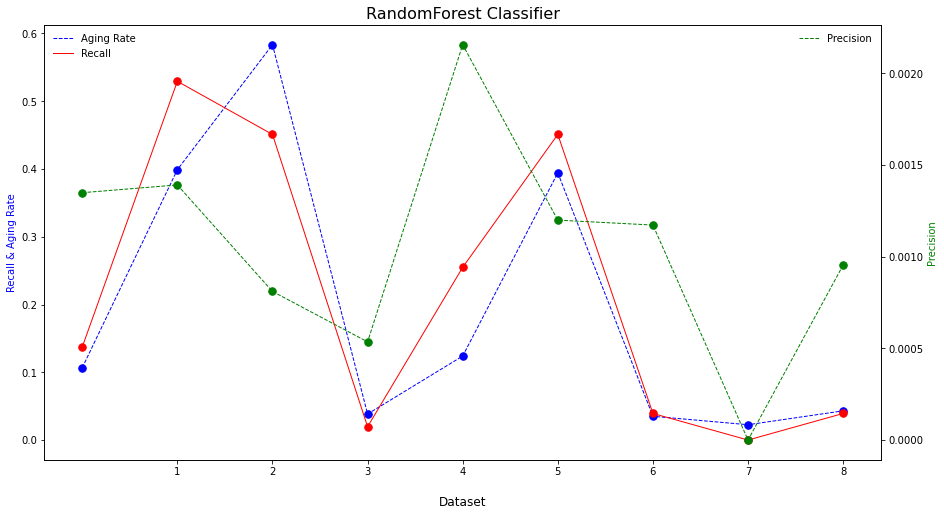

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,7.0,5183.0,44.0,43415.0,0.001349,0.137255,0.106683,1.286573,0.001336,0.113517
dataset2,1.000000,3002.0,3002.0,27.0,19382.0,24.0,29216.0,0.001391,0.529412,0.398960,1.326980,0.001387,0.447126
dataset3,1.000000,3038.0,3038.0,23.0,28361.0,28.0,20237.0,0.000810,0.450980,0.583445,0.772962,0.000809,0.000000
dataset4,1.000000,3038.0,3038.0,1.0,1867.0,50.0,46731.0,0.000535,0.019608,0.038398,0.510654,0.000521,0.000000
dataset5,1.006623,3040.0,3020.0,13.0,6017.0,38.0,42581.0,0.002156,0.254902,0.123949,2.056505,0.002138,0.284795
dataset6,1.014348,3040.0,2997.0,23.0,19158.0,28.0,29440.0,0.001199,0.450980,0.394273,1.143827,0.001196,0.343914
dataset7,1.000000,3040.0,3040.0,2.0,1704.0,49.0,46894.0,0.001172,0.039216,0.035068,1.118291,0.001138,0.029436
dataset8,1.000000,3040.0,3040.0,0.0,1099.0,51.0,47499.0,0.000000,0.000000,0.022590,0.000000,NaN,0.000000
dataset9,10.000000,3040.0,304.0,2.0,2094.0,49.0,46504.0,0.000954,0.039216,0.043084,0.910212,0.000932,0.000000


In [6]:
line_chart(table_setC, title = 'RandomForest Classifier')
table_setC

### Export

In [7]:
savedate = '20220405'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'RandomForest'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'RandomForest')